##ANN

## Imports

In [ ]:
!pip install surprise
!pip uninstall tensorflow
!pip install tensorflow==1.15
!pip install annoy

In [ ]:

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
import sys
import seaborn as sns
from timeit import Timer
from datetime import datetime

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

## Get data from drive

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "1FFYnZRIuzQLeBkDUuJpK_oRtUmdxMd9O"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_dataset.csv')  
data = pd.read_csv('final_dataset.csv')

In [ ]:
data.drop(columns=['Unnamed: 0','timestamp','date','year'],inplace=True)
data.head()

,userId,movieId,rating
0,2,849,3.5
1,339,849,5.0
2,1707,849,2.5
3,2040,849,1.0
4,2759,849,4.0


## Make train-test split

In [ ]:
# Splitting Main dataset to a train and a test dataset
user_freq=data.groupby(['userId']).size().reset_index(name='counts')
users_lt3=user_freq[user_freq['counts']<3][['userId']]
users_ge3=user_freq[user_freq['counts']>=3][['userId']]
train1 = pd.merge(data, users_lt3, on=['userId'],how='inner')
data1 = pd.merge(data, users_ge3, on=['userId'],how='inner')
random.seed(2)
test=data1.groupby('userId').sample(frac=.3, random_state=2)
test_idx = data1.index.isin(test.index.to_list())
train = train1.append(data1[~test_idx])



train_df = train
test_df = test

##  Before Applying ANN, it is a prerequisite that we have our latent matrix i.e. U and V matrices ready.
Therefore, I am reusing code from the SVD Collaborative Filtering model to get the latent matrix.

In [ ]:
train_df = train
test_df = test

def create_SVD_UV(train,test,user_freq):
  train=train[['userId', 'movieId', 'rating']]
  test=test[['userId', 'movieId', 'rating']]
  reader = Reader(rating_scale=(1,5))
  train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
  test = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader=reader)
  raw_ratings = test.raw_ratings
  threshold = int(1 * len(raw_ratings))
  A_raw_ratings = raw_ratings[:threshold]
  test = test.construct_testset(A_raw_ratings)

  raw_ratings1 = train.raw_ratings
  threshold = int(1 * len(raw_ratings1))
  B_raw_ratings = raw_ratings1[:threshold]
  train_test = train.construct_testset(B_raw_ratings)

  model = SVD(n_epochs=50,n_factors=15,reg_all=0.1,lr_all=0.02)
  trainset = train.build_full_trainset()
  model.fit(trainset)

  # Retrieiving inner ids, as used by surprise package during model training
  user_inner_ids = [x for x in trainset.all_users()]
  item_inner_ids = [i for i in trainset.all_items()]

  # All ids mapped back to values in the actual train set 
  user_raw_ids = [trainset.to_raw_uid(x) for x in user_inner_ids]
  item_raw_ids = [trainset.to_raw_iid(x) for x in item_inner_ids]

  U = model.pu 
  V = model.qi

  return U, V, trainset, user_inner_ids



U,V, trainset, user_inner_ids = create_SVD_UV(train,test,user_freq)








  







# Exploratory Data Analysis

In [ ]:
# Movie frequency per user for all users in our training dataset
user_freq = train_df.groupby('userId', as_index=False).agg(num_movies=('movieId','count'))

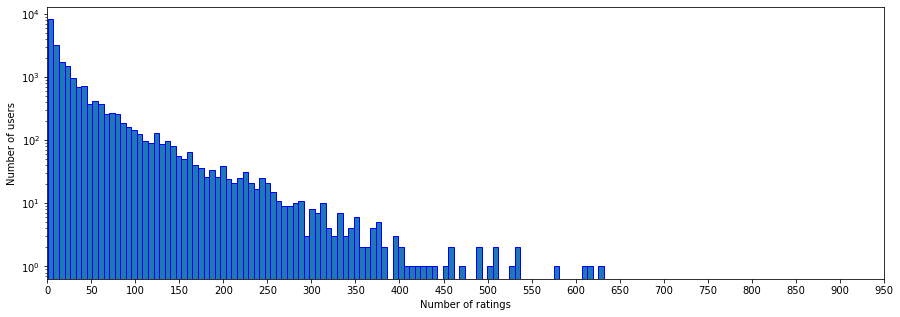

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,1000,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()


We have a lot of users who have rated more than 50 ratings.
We will be looking at using nearest neighbours to reduce the size of the the user-movie pairs in the train dataset.

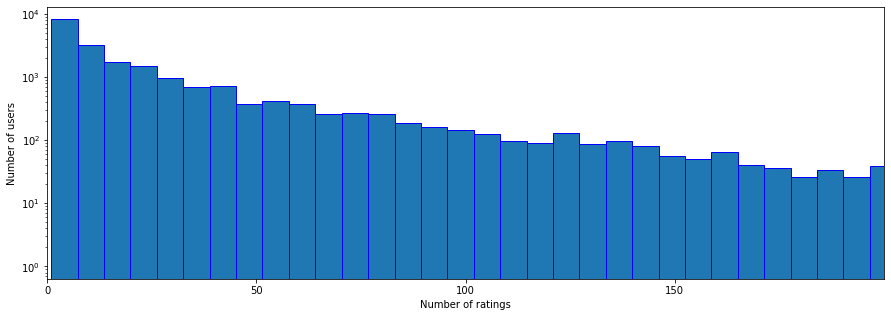

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_movies'], bins=100, edgecolor='b', log=True)
plt.xlim(0,200)
plt.xticks(np.arange(0,200,50))
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

The latent matrix is a numpy array of shape (n_items, n_factors. The first raw corresponds to the first raw item id (see this: http://surprise.readthedocs.io/en/latest/FAQ.html#what-are-raw-and-inner-ids), the second correspond to the second raw item id, etc...

# Annoy package 

Annoy is a C++ library with Python bindings that builds random projection trees. An index is built with a forest of k trees, where k is a tunable parameter that trades off between precision and performance. It also creates large read-only, file-based data structures that are mapped into memory so that many processes can share the data.

In [ ]:
from annoy import AnnoyIndex

From our ANN User-User Similarity notebook, we find that the optimal number of trees should be about 50. So we assume 50 to be our best value for number of trees for the User-Item Similarity Task.

In [ ]:
def run_ann(user_inner_ids, V, train_df):
  #To be used for serialized process; user item search

  f = 15 # n_factors
  t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i,v in zip(user_inner_ids,V):
      t.add_item(i, v)

  t.build(100)
  t.save('test_user_item.ann')


  u = AnnoyIndex(f, 'angular')
  u.load('test_user_item.ann') 
  # super fast, will just map the file

  user_ids_nn = list(user_freq[user_freq['num_movies']>50]['userId'].values)

  def find_nn_greater_than_k(user_id, k=100):
    return t.get_nns_by_vector(U[trainset.to_inner_uid(user_id)], k) 

  user_nn_items = list(map(find_nn_greater_than_k,user_ids_nn))
  user_nn_items_dict={}
  for userid,items in zip(user_ids_nn,user_nn_items):
    user_nn_items_dict[userid] = [trainset.to_raw_iid(i) for i in items]
  
  user_nn_items_df = pd.concat({k: pd.Series(v) for k, v in user_nn_items_dict.items()})
  user_nn_items_df = user_nn_items_df.reset_index()
  user_nn_items_df = user_nn_items_df.drop(columns=['level_1'])
  user_nn_items_df.rename(columns={'level_0': 'userId', 0: 'movieId'}, inplace=True)

  merged_df= pd.merge(train_df,user_nn_items_df,how='inner',on=['userId','movieId'])

  #concatenate data for users who rated less than 50 movies merged_df
  user_ids_without_nn = set(list(train_df['userId'].unique())) - set(user_ids_nn)
  user_ids_without_nn_df = pd.DataFrame(user_ids_without_nn,columns =['userId']) 

  user_ids_without_nn_df = pd.merge(train_df,user_ids_without_nn_df,how='inner',on='userId')

  # ANN reduced matrix
  train_concat_df = pd.concat([user_ids_without_nn_df, merged_df])
  #train_concat_df = merged_df
  return train_concat_df


train_concat_df = def run_ann(user_inner_ids, V, train_df)








  

  






In [ ]:
#To be used for serialized process; user item search

f = 15 # n_factors
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i,v in zip(user_inner_ids,V):
    t.add_item(i, v)

t.build(100)
t.save('test_user_item.ann')

True

In [ ]:

u = AnnoyIndex(f, 'angular')
u.load('test_user_item.ann') 
# super fast, will just map the file

True

### Creating filtered training model with reduced rows per user 

In [ ]:
user_ids_nn = list(user_freq[user_freq['num_movies']>50]['userId'].values)

In [ ]:
len(user_ids_nn)

3533

In [ ]:
def find_nn_greater_than_k(user_id, k=100):
  return t.get_nns_by_vector(U[trainset.to_inner_uid(user_id)], k) 

In [ ]:
user_nn_items = list(map(find_nn_greater_than_k,user_ids_nn))
user_nn_items_dict={}
for userid,items in zip(user_ids_nn,user_nn_items):
  user_nn_items_dict[userid] = [trainset.to_raw_iid(i) for i in items]

In [ ]:
user_nn_items_df = pd.concat({k: pd.Series(v) for k, v in user_nn_items_dict.items()})
user_nn_items_df = user_nn_items_df.reset_index()
user_nn_items_df = user_nn_items_df.drop(columns=['level_1'])
user_nn_items_df.rename(columns={'level_0': 'userId', 0: 'movieId'}, inplace=True)
user_nn_items_df

,userId,movieId
0,73,2065
1,73,48774
2,73,1228
3,73,8340
4,73,1178
...,...,...
353295,283184,8966
353296,283184,165549
353297,283184,39381
353298,283184,48696


In [ ]:
len(user_nn_items_df['userId'].unique())

3533

In [ ]:
merged_df= pd.merge(train_df,user_nn_items_df,how='inner',on=['userId','movieId'])
len(merged_df['userId'].unique())

3531

In [ ]:
#concatenate data for users who rated less than 50 movies merged_df
user_ids_without_nn = set(list(train_df['userId'].unique())) - set(user_ids_nn)
user_ids_without_nn_df = pd.DataFrame(user_ids_without_nn,columns =['userId']) 
len(user_ids_without_nn_df['userId'].unique())

17441

In [ ]:
user_ids_without_nn_df = pd.merge(train_df,user_ids_without_nn_df,how='inner',on='userId')
len(user_ids_without_nn_df['userId'].unique())

17441

In [ ]:
# ANN reduced matrix
train_concat_df = pd.concat([user_ids_without_nn_df, merged_df])
#train_concat_df = merged_df
train_concat_df

,userId,movieId,rating
0,16421,849,4.5
1,16421,2746,4.0
2,260732,849,3.0
3,260732,256,1.0
4,102234,1186,3.0
...,...,...,...
57896,139879,132480,4.5
57897,139879,72641,5.0
57898,139879,34534,5.0
57899,139879,79139,4.0


In [ ]:
print(len(train_concat_df['userId'].unique()))

20972


### End of code to produce filtered matrix

##NCF

In [ ]:
from ncf_singlenode import *
from dataset import Dataset as NCFDataset
from constants import SEED as DEFAULT_SEED
SEED = DEFAULT_SEED

In [ ]:
def run_ncf(train_concat_df,test_df):
  train=train_df[['userId' ,'movieId' ,'rating']]
  test=test_df[['userId' ,'movieId' ,'rating']]
  train.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)
  test.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)
  test=pd.merge(test,pd.DataFrame(np.unique(train['userID']),columns=['userID']),on=['userID'],how='inner')
  data = NCFDataset(train=train, test=test, seed=SEED)
  
  EPOCHS = 100
  BATCH_SIZE = 256

  model = NCF (
      n_users=data.n_users, 
      n_items=data.n_items,
      model_type="NeuMF",
      n_factors=4,
      layer_sizes=[16,8,4],
      n_epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      learning_rate=1e-3,
      verbose=10,
      seed=SEED)
  model.fit(data)

  users, items, preds = [], [], []
  item = list(train.itemID.unique())
  for user in train.userID.unique():
      user = [user] * len(item) 
      users.extend(user)
      items.extend(item)
      preds.extend(list(model.predict(user, item, is_list=True)))

  all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

  merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
  all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

  return all_predictions



In [ ]:
train=train_df[['userId' ,'movieId' ,'rating']]
test=test_df[['userId' ,'movieId' ,'rating']]
train.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)
test.rename({'userId': 'userID', 'movieId': 'itemID'}, axis=1, inplace=True)

In [ ]:
test=pd.merge(test,pd.DataFrame(np.unique(train['userID']),columns=['userID']),on=['userID'],how='inner')

In [ ]:
data = NCFDataset(train=train, test=test, seed=SEED)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 256

model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.fit(data)

In [ ]:
from timer import Timer
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))
all_predictions.to_csv('/content/drive/MyDrive/main_data/ncf_ann100_data_preds.csv')


In [ ]:
all_predictions.to_csv('/content/drive/MyDrive/main_data/ncf_ann100_data_preds.csv')
